In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import PathPatch

In [2]:
fp_data1 = "../results/metrics/"
FNs1 = glob.glob(fp_data1+"Metric*SummedDegree-0.50*2000*0.1_0.001_120_8_10*.tsv")
fp_data2 = "../results/wormhole_metrics/"
FNs2 = glob.glob(fp_data2+"Metric*SummedDegree-0.50*2000*0.1_0.001_120_8_10*.tsv")
FNs = FNs1 + FNs2
df_results = pd.DataFrame()
for aFN in FNs:
    df_tmp = pd.read_csv(aFN,sep="\t")
    if df_tmp.shape[0] == 0:
        # this is for dr BioGRID where there are no terms
        continue
    # remove hs_mm that has AllOnes embeddings
    if ("AllOnes" in aFN) and ("hs_mm" in aFN) and ("Pecanpy" in aFN):
        continue
    GSCtmp = "_".join(df_tmp["GSC_info"].to_list()[0].split("__")[1].split("_")[0:2])
    df_tmp["GSC"] = [GSCtmp] * df_tmp.shape[0]
    df_results = pd.concat([df_results,df_tmp])
df_results.head()

,GSC_info,network,species,connections,feature_type,model_info,ID,name,num_train_pos,num_train_all,num_test_pos,num_test_all,avgp,log2p,auroc,PTopK,GSC
0,MethodNum-0__Monarch_dm_20_200_0.5_0.5,BioGRID_raw,dm_hs,eggnog_direct_SummedDegree-0.50,Pecanpy_2000_SparseOTF_0.1_0.001_120_8_10_weig...,NoScaling__LR_l2_1.0,FBcv:0000360,decreased cell size,173,3613,12,2626,0.071699,3.971776,0.842642,1,Monarch_dm
1,MethodNum-0__Monarch_dm_20_200_0.5_0.5,BioGRID_raw,dm_hs,eggnog_direct_SummedDegree-0.50,Pecanpy_2000_SparseOTF_0.1_0.001_120_8_10_weig...,NoScaling__LR_l2_1.0,FBcv:0000449,abnormal planar polarity,162,4043,13,2672,0.006300,0.372935,0.493100,0,Monarch_dm
2,MethodNum-0__Monarch_dm_20_200_0.5_0.5,BioGRID_raw,dm_hs,eggnog_direct_SummedDegree-0.50,Pecanpy_2000_SparseOTF_0.1_0.001_120_8_10_weig...,NoScaling__LR_l2_1.0,FBcv:0006002,decreased fecundity,139,3818,10,2634,0.008156,1.103107,0.547675,0,Monarch_dm
0,MethodNum-0__Monarch_dm_20_200_0.5_0.5,BioGRID_raw,ce_dm_dr_hs_mm_sc,eggnog_direct_SummedDegree-0.50,Pecanpy_2000_SparseOTF_0.1_0.001_120_8_10_weig...,NoScaling__LR_l2_1.0,FBcv:0000360,decreased cell size,173,3613,12,2626,0.107377,4.554450,0.715889,1,Monarch_dm
1,MethodNum-0__Monarch_dm_20_200_0.5_0.5,BioGRID_raw,ce_dm_dr_hs_mm_sc,eggnog_direct_SummedDegree-0.50,Pecanpy_2000_SparseOTF_0.1_0.001_120_8_10_weig...,NoScaling__LR_l2_1.0,FBcv:0000449,abnormal planar polarity,162,4043,13,2672,0.005961,0.293088,0.437209,0,Monarch_dm


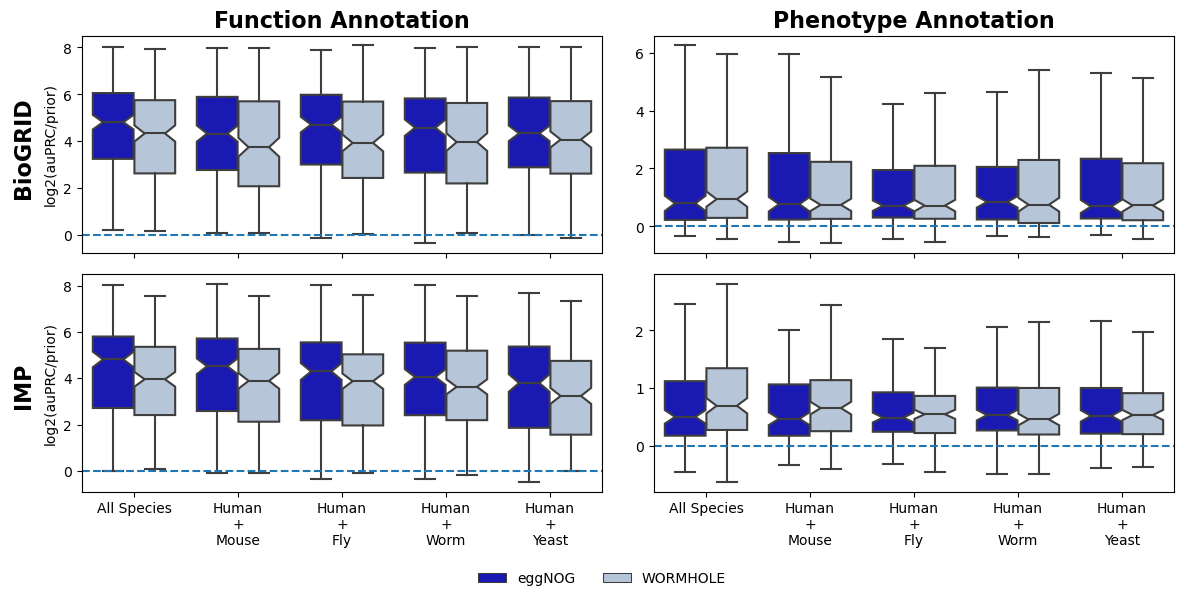

In [8]:
%%capture --no-display
def make_plots3():
    fig, ax = plt.subplots(2,2,figsize=(12,6))
    for idx2, anet in enumerate(["BioGRID_raw","IMP_raw"]):
        for idx1, aGSC in enumerate(["GO", "Monarch"]):
            df_tmp = df_results[(df_results["network"]==anet)&
                                (df_results["GSC"]==f"{aGSC}_hs")]
            species_tmp = df_tmp["species"].to_list()
            cons_tmp = df_tmp["connections"].to_list()
            new_hue = []
            for idx, item in enumerate(cons_tmp):
                if "wormhole" in item:
                    new_hue.append("WORMHOLE")
                else:
                    new_hue.append("eggNOG")
            new_xlabel = []
            for idx, item in enumerate(species_tmp):
                if "ce_dm" in item:
                    new_xlabel.append("All Species")
                elif "_" not in item:
                    new_xlabel.append("Human\nOnly")
                elif "ce_hs" in item:
                    new_xlabel.append("Human\n+\nWorm")
                elif "dm_hs" in item:
                    new_xlabel.append("Human\n+\nFly")
                elif "dr_hs" in item:
                    new_xlabel.append("Human\n+\nFish")
                elif "hs_mm" in item:
                    new_xlabel.append("Human\n+\nMouse")
                elif "hs_sc" in item:
                    new_xlabel.append("Human\n+\nYeast")
            df_tmp["hue"] = new_hue
            df_tmp["xlabel"] = new_xlabel
            sns.boxplot(data=df_tmp,x="xlabel",y="log2p",hue="hue",
                        notch=True,showfliers=False,ax=ax[idx2,idx1],
                        order=["All Species","Human\n+\nMouse","Human\n+\nFly",
                               "Human\n+\nWorm","Human\n+\nYeast"],
                        hue_order = ["eggNOG","WORMHOLE"],
                        palette = ["mediumblue","lightsteelblue"])
            ax[idx2,idx1].get_legend().remove()
            ax[idx2,idx1].axhline(ls="--")
            ax[idx2,idx1].set_xlabel("")
            if idx2 == 0:
                ax[idx2,idx1].set_xticklabels("")
            else:
                ax[idx2,idx1].set_xticklabels(ax[idx2,idx1].get_xticklabels(),fontsize=10)
            if idx1 == 1:
                ax[idx2,idx1].set_ylabel("")
            else:
                ax[idx2,idx1].set_ylabel("log2(auPRC/prior)",fontsize=10)
    ax[0,0].set_title("Function Annotation",fontsize=16,fontweight="bold")
    ax[0,1].set_title("Phenotype Annotation",fontsize=16,fontweight="bold")
    plt.annotate("BioGRID",xy=(0.01,0.68),xycoords="figure fraction",
                 rotation="vertical",fontsize=16,fontweight="bold")
    plt.annotate("IMP",xy=(0.01,0.33),xycoords="figure fraction",
                 rotation="vertical",fontsize=16,fontweight="bold")
    plt.subplots_adjust(bottom=0.18,hspace=0.1,wspace=0.1,left=0.07,right=0.98,top=0.94)
    ax[1,1].legend(ncol=5, loc = "center", bbox_to_anchor=(-0.1, -0.4), \
        frameon=False, fontsize=10)
    # adjust_box_widths(fig, 0.8)
    fig.savefig('../figures/FigSM10.pdf')
make_plots3()

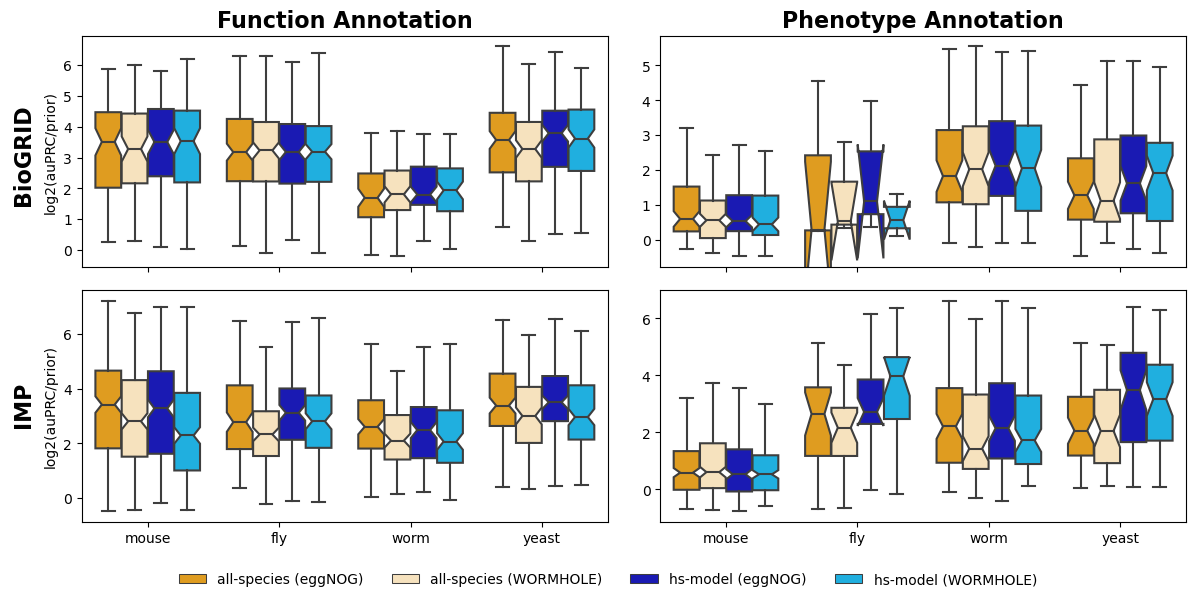

In [9]:
%%capture --no-display
def make_plots2():
    fig, ax = plt.subplots(2,2,figsize=(12,6))
    for idx1, GSC in enumerate(["GO","Monarch"]):
        for idx2, anet in enumerate(["BioGRID_raw","IMP_raw"]):
            if GSC == "GO":
                remove = "Monarch"
            else:
                remove = "GO"

            df_tmp = df_results[(df_results["network"]==anet)&
                                (df_results["GSC"]!="%s_hs"%GSC)&
                                (~df_results["GSC"].str.contains(remove))&
                                (df_results["GSC"]!="DisNet_hs")]
            species_tmp = df_tmp["species"].to_list()
            cons_tmp = df_tmp["connections"].to_list()
            new_features = []
            for idx, item in enumerate(species_tmp):
                # get orthology type
                if "wormhole" in cons_tmp[idx]:
                    myorth = "WORMHOLE"
                else:
                    myorth = "eggNOG"
                if item == "ce_dm_dr_hs_mm_sc":
                    new_features.append(f"all-species ({myorth})")
                elif "hs" in item:
                    new_features.append(f"hs-model ({myorth})")
                else:
                    new_features.append(f"model ({myorth})")
            df_tmp["features"] = new_features 
            df_tmp = df_tmp.sort_values(by=["GSC"])
            df_tmp.head()
            myhueorder = ["all-species (eggNOG)", "all-species (WORMHOLE)",
                          "hs-model (eggNOG)","hs-model (WORMHOLE)"]
            myorder = [f"{GSC}_mm",f"{GSC}_dm",f"{GSC}_ce",f"{GSC}_sc"]
            sns.boxplot(data=df_tmp,x="GSC",y="log2p",hue="features",
                        notch=True,showfliers=False,hue_order=myhueorder,
                        order=myorder,ax=ax[idx2,idx1],
                        palette=["orange","moccasin",
                                 "mediumblue","deepskyblue"])
            if (idx1 == 1) and (idx2 == 1):
                pass
            else:    
                ax[idx2,idx1].get_legend().remove()
            if idx2 == 1:
                ax[idx2,idx1].set_xlabel("")
                ax[idx2,idx1].set_xticklabels(["mouse","fly","worm","yeast"])
            else:
                ax[idx2,idx1].set_xlabel("")
                ax[idx2,idx1].set_xticklabels("")
            if idx1 == 1:
                ax[idx2,idx1].set_ylabel("")
            else:
                ax[idx2,idx1].set_ylabel("log2(auPRC/prior)")
    ax[1,1].legend(ncol=4,loc="center",bbox_to_anchor=(-0.1,-0.25),frameon=False)
    ax[0,0].set_title("Function Annotation",fontsize=16,fontweight="bold")
    ax[0,1].set_title("Phenotype Annotation",fontsize=16,fontweight="bold")
    plt.annotate("BioGRID",xy=(0.01,0.67),xycoords="figure fraction",
                 rotation="vertical",fontsize=16,fontweight="bold")
    plt.annotate("IMP",xy=(0.01,0.30),xycoords="figure fraction",
                 rotation="vertical",fontsize=16,fontweight="bold")
    plt.subplots_adjust(bottom=0.13,hspace=0.1,wspace=0.1,left=0.07,right=0.99,top=0.94)
    fig.savefig('../figures/FigSM11.pdf')
make_plots2()